# Simple Clustering and Linear Sweep Search

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from armscan_env.util.visualizations import show_slices

Load the dataset

In [3]:
path_to_mri = os.path.join("../..", "data", "labels", "00001_labels.nii")
mri_1_label = sitk.ReadImage(path_to_mri)
mri_1_label_data = sitk.GetArrayFromImage(mri_1_label)
print(f"{mri_1_label_data.shape=}")

mri_1_label_data.shape=(61, 864, 606)


In this notebook, we are going to explain the process of searching the carpal tunnel along one axis using a simple clustering algorithm. The first step is to visualize the data to understand the anatomy of the hand at the level of the carpal tunnel. We will then use a simple clustering algorithm to identify the number of features present in each image. Based on the number of features and their relative positions, we will be able to identify the carpal tunnel, basing on its anatomical description.

Since we are not changing the orientation of the slices along the hand, we are bound to a sub-optimal visualization along the axis on which the images have been stacked. This is not exactly transversal to the carpal tunnel, so our anatomical description will be relative to this suboptimal orientation. However, we can still demonstrate that the anatomical description of the region of interest is enough to optimize the navigation.

The following images are slices in proximity of the carpal tunnel area.

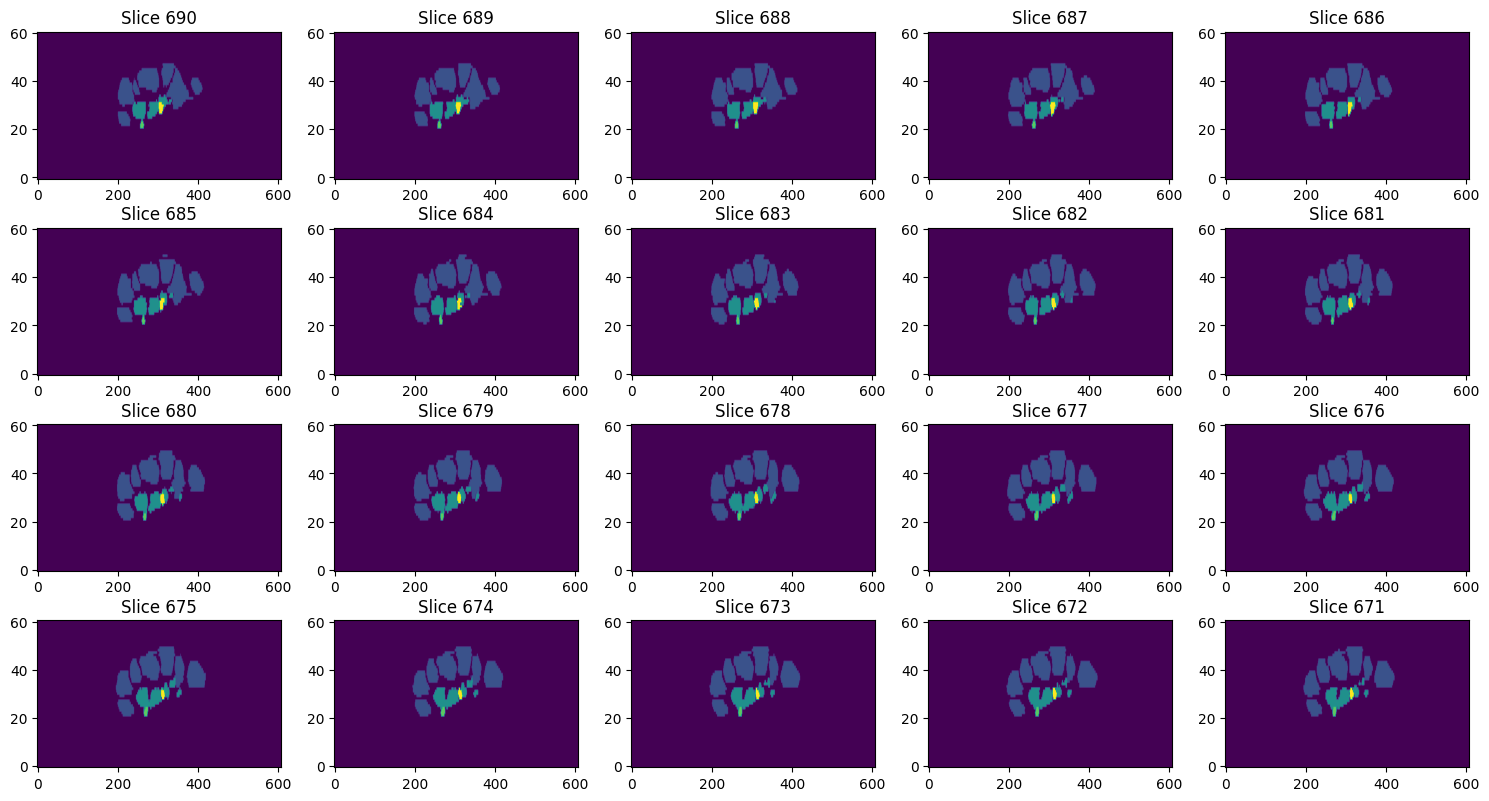

In [4]:
show_slices(data=mri_1_label_data, start=690, end=20, lap=1)
plt.show()

The values of the labels are going to be used to identify the clusters of tissues and reason about the anatomy seen in the image.

In [5]:
tissues = {
    "bones": 1,
    "tendons": 2,
    "ulnar": 3,
}

The function `cluster_iter` is going to be used to identify the clusters of tissues in the image. It iterates over the tissues in the dictionary and identifies the clusters of each tissue. The clustering algorithm uses a center-symmetric filter to identify clusters of neighboring pixels with the same value. The algorithm is based on the `label` function from the `scipy.ndimage` package. The function returns a dictionary with the clusters of tissues and the center of each of them.

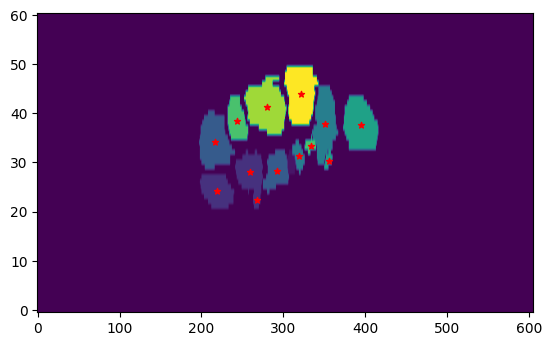

In [6]:
from armscan_env.clustering import cluster_iter
from armscan_env.util.visualizations import show_clusters

clusters_679 = cluster_iter(tissues, mri_1_label_data[:, 679, :])
show_clusters(clusters_679, mri_1_label_data[:, 679, :])
plt.show()

Visualizing slices of the hand at different levels, is going to make clear why it is enough to reason about the anatomy of one slice to identify the region of interest. 

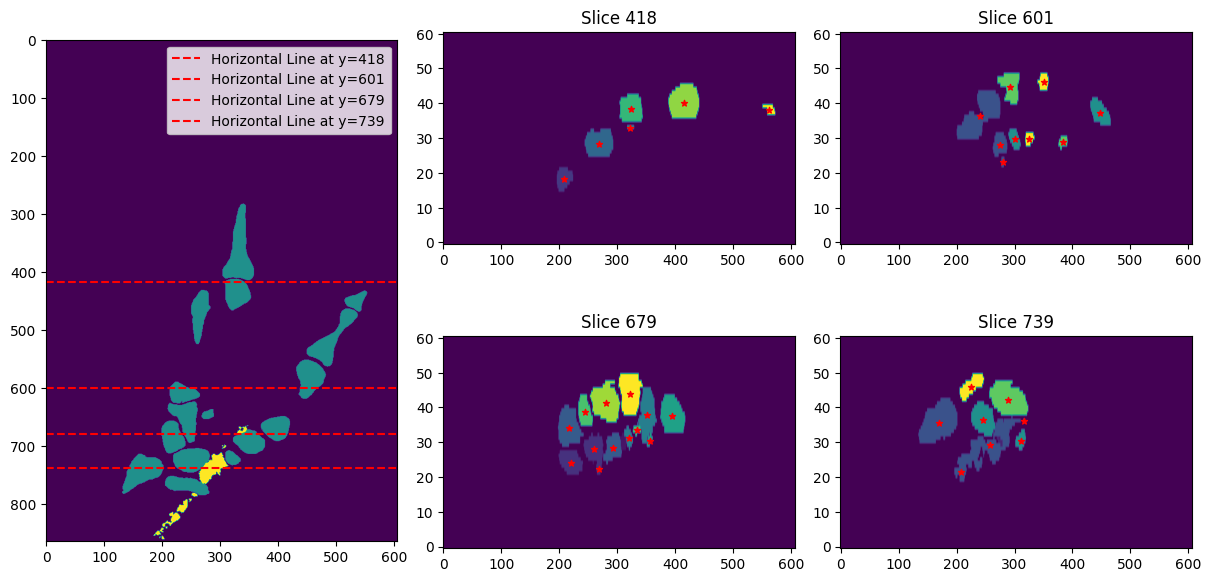

In [7]:
# Create a figure and a gridspec with two rows and two columns
fig = plt.figure(constrained_layout=True, figsize=(12, 6))
gs = fig.add_gridspec(2, 3)

# Add subplots
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])


ax1.axhline(y=418, color="red", linestyle="--", label=f"Horizontal Line at y={418}")
ax1.axhline(y=601, color="red", linestyle="--", label=f"Horizontal Line at y={601}")
ax1.axhline(y=679, color="red", linestyle="--", label=f"Horizontal Line at y={679}")
ax1.axhline(y=739, color="red", linestyle="--", label=f"Horizontal Line at y={739}")
ax1.imshow(mri_1_label_data[35, :, :], label="Hand")
ax1.legend()

clusters_418 = cluster_iter(tissues, mri_1_label_data[:, 418, :])
show_clusters(clusters_418, mri_1_label_data[:, 418, :], ax2)
ax2.set_title("Slice 418")

cluster_601 = cluster_iter(tissues, mri_1_label_data[:, 601, :])
show_clusters(cluster_601, mri_1_label_data[:, 601, :], ax3)
ax3.set_title("Slice 601")

show_clusters(clusters_679, mri_1_label_data[:, 679, :], ax4)
ax4.set_title("Slice 679")

cluster_739 = cluster_iter(tissues, mri_1_label_data[:, 739, :])
show_clusters(cluster_739, mri_1_label_data[:, 739, :], ax5)
ax5.set_title("Slice 739")

plt.show()

The clustering algorithm does not just give us information about the number of tissues clusters, but also about their position. Hence, it is possible to reason about the orientation of the image and the relation of the tissues to one another.

In [8]:
clusters_679 = cluster_iter(tissues, mri_1_label_data[:, 679, :])

bones_centers = [cluster.center for _, cluster in enumerate(clusters_679.bones)]
ligament_centers = [cluster.center for _, cluster in enumerate(clusters_679.tendons)]

bones_center = np.mean(bones_centers, axis=0)
print("bones_center: ", bones_center)
ligament_center = np.mean(ligament_centers, axis=0)
print("ligament_center: ", ligament_center)
ulnar_center = clusters_679.ulnar[0].center
print("ulnar_center: ", ulnar_center)

bones_center:  [ 36.76763969 289.53353614]
ligament_center:  [ 30.23236792 312.05577456]
ulnar_center:  (22.26923076923077, 268.2307692307692)


The function `anatomy_based_rwd` calculates the score of each image. This offers an observable reward, which can be used to optimize the navigation problem with classical search methods as well as with RL algorithms. The score is based on the number of clusters recognized for each tissue, which should be equal to the `n_landmarks` parameter. If some of the tissues are not present at all, this is more hardly penalized, because it means that the navigation is far off. Moreover, the score takes into account the position of the landmarks: in particular it checks whether the ulnar artery lies underneath the tendons clusters or not. The score is then normalized to sum up to one.

We tuned the score function to our sub-optimal region of interest: it returns a zero loss for the slice showing the described anatomical conformation.

In [9]:
from armscan_env.envs.rewards import anatomy_based_rwd

anatomy_based_rwd(clusters_679, n_landmarks=[7, 5, 1])

0.0

Performing a linear sweep search along the axis of the hand, we can identify the optimal region that returns a zero loss. We can also see that the loss converges to zero as we approach the optimal region.

In [10]:
sweep_loss = []
zero_loss_clusters = []

for i in range(mri_1_label_data.shape[1]):
    clusters = cluster_iter(tissues, mri_1_label_data[:, i, :])
    loss = anatomy_based_rwd(clusters, n_landmarks=[7, 5, 1])
    sweep_loss.append(loss)
    if loss == 0:
        zero_loss_clusters.append(clusters)
    print(f"Loss for slice {i}: {sweep_loss[i]}")

Loss for slice 0: 1.0999999999999999
Loss for slice 1: 1.0999999999999999
Loss for slice 2: 1.0999999999999999
Loss for slice 3: 1.0999999999999999
Loss for slice 4: 1.0999999999999999
Loss for slice 5: 1.0999999999999999
Loss for slice 6: 1.0999999999999999
Loss for slice 7: 1.0999999999999999
Loss for slice 8: 1.0999999999999999
Loss for slice 9: 1.0999999999999999
Loss for slice 10: 1.0999999999999999
Loss for slice 11: 1.0999999999999999
Loss for slice 12: 1.0999999999999999
Loss for slice 13: 1.0999999999999999
Loss for slice 14: 1.0999999999999999
Loss for slice 15: 1.0999999999999999
Loss for slice 16: 1.0999999999999999
Loss for slice 17: 1.0999999999999999
Loss for slice 18: 1.0999999999999999
Loss for slice 19: 1.0999999999999999
Loss for slice 20: 1.0999999999999999
Loss for slice 21: 1.0999999999999999
Loss for slice 22: 1.0999999999999999
Loss for slice 23: 1.0999999999999999
Loss for slice 24: 1.0999999999999999
Loss for slice 25: 1.0999999999999999
Loss for slice 26: 1.0

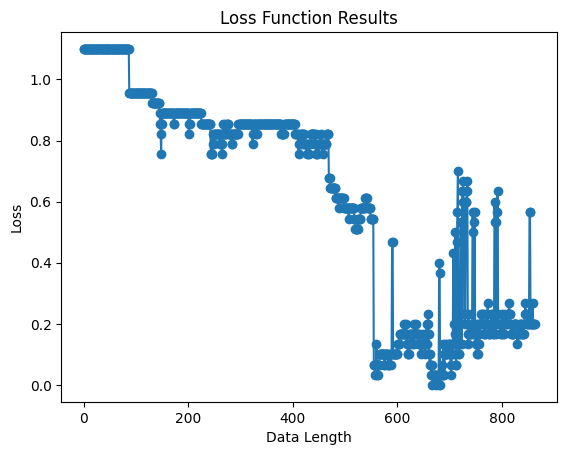

In [11]:
plt.plot(range(len(sweep_loss)), sweep_loss, marker="o")

plt.xlabel("Data Length")
plt.ylabel("Loss")
plt.title("Loss Function Results")

plt.show()

We can visualize the slices that return a zero loss to check whether this approach is valid.

4 indices return a zero loss:  [667 674 679 682]


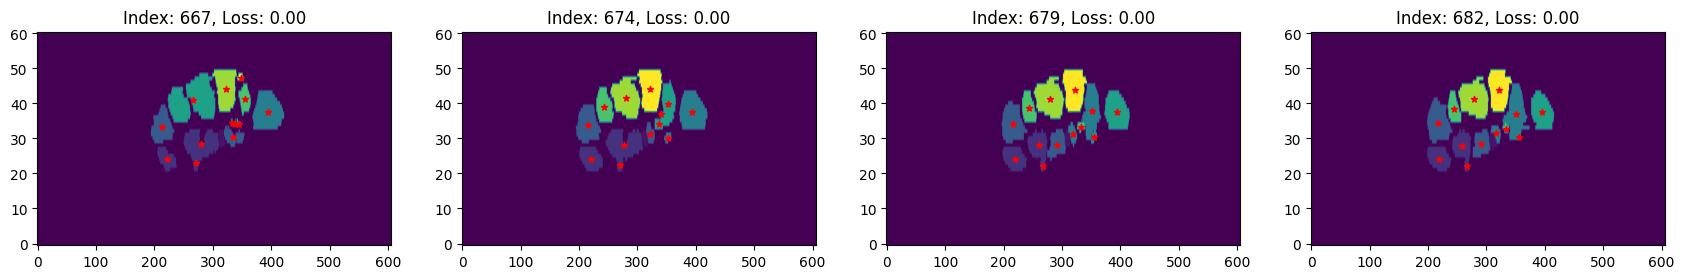

In [12]:
zero_loss_indices = np.where(np.array(sweep_loss) == 0)[0]
print(f"{len(zero_loss_indices)} indices return a zero loss: ", zero_loss_indices)

fig, axes = plt.subplots(1, 4, figsize=(21, 6))
axes = axes.flatten()
for i, idx in enumerate(zero_loss_indices):
    axes[i] = show_clusters(
        tissue_clusters=zero_loss_clusters[i],
        slice=mri_1_label_data[:, idx, :],
        ax=axes[i],
    )
    axes[i].set_title(f"Index: {idx}, Loss: {sweep_loss[idx]:.2f}")

plt.show()

As we can see, the results are quite promising, but the clustering algorithm is not really identifying the clusters robustly. In the next notebook, we will show the performance using a different clustering algorithm.